In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage, Compose, Resize, Normalize
from PIL import Image
import matplotlib.pyplot as plt
from utils.plots import plot_tensor, plot_tensors
import torchvision.datasets as datasets
from tqdm.notebook import tqdm, trange

### Instanciación de una capa convolucional con templates

In [4]:
class InterpretableConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, feature_map_size, tau=0.5, beta=4.0, alpha=0.95):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=True)
        self.tau = tau
        self.beta = beta
        self.alpha = alpha
        self.n = feature_map_size
        self.templates = self._generate_templates()

    def forward(self, x):
        x = F.relu(self.conv(x))
        masks = self._assign_masks(x)
        masked_x = x * masks
        return masked_x * (masked_x > 0)

    def _generate_templates(self):
        templates = []
        for i in range(self.n):
            for j in range(self.n):
                t = torch.full((self.n, self.n), -self.tau)
                for x in range(self.n):
                    for y in range(self.n):
                        dist = abs(x - i) + abs(y - j)
                        t[x, y] = self.tau * max(1 - self.beta * dist / self.n, -1)
                templates.append(t)
        return torch.stack(templates)

    def _assign_masks(self, x):

        B, C, H, W = x.shape
        
        x_flat = x.view(B * C, H, W)
        masks = []

        for fmap in x_flat:
            mu_hat = torch.argmax(fmap.view(-1))
            i, j = mu_hat // self.n, mu_hat % self.n
            idx = i * self.n + j
            mask = self.templates[idx]
            masks.append(mask)

        masks = torch.stack(masks).view(B, C, H, W).to(x.device)
        return masks

In [5]:
filters = 3
interpretable_cnn = InterpretableConvLayer(3, filters, 3, 32)

### Gráfico de los templates en la capa convolucional interpretable

/Users/valentinaferuere/Projects/interpretability/utils/plots.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


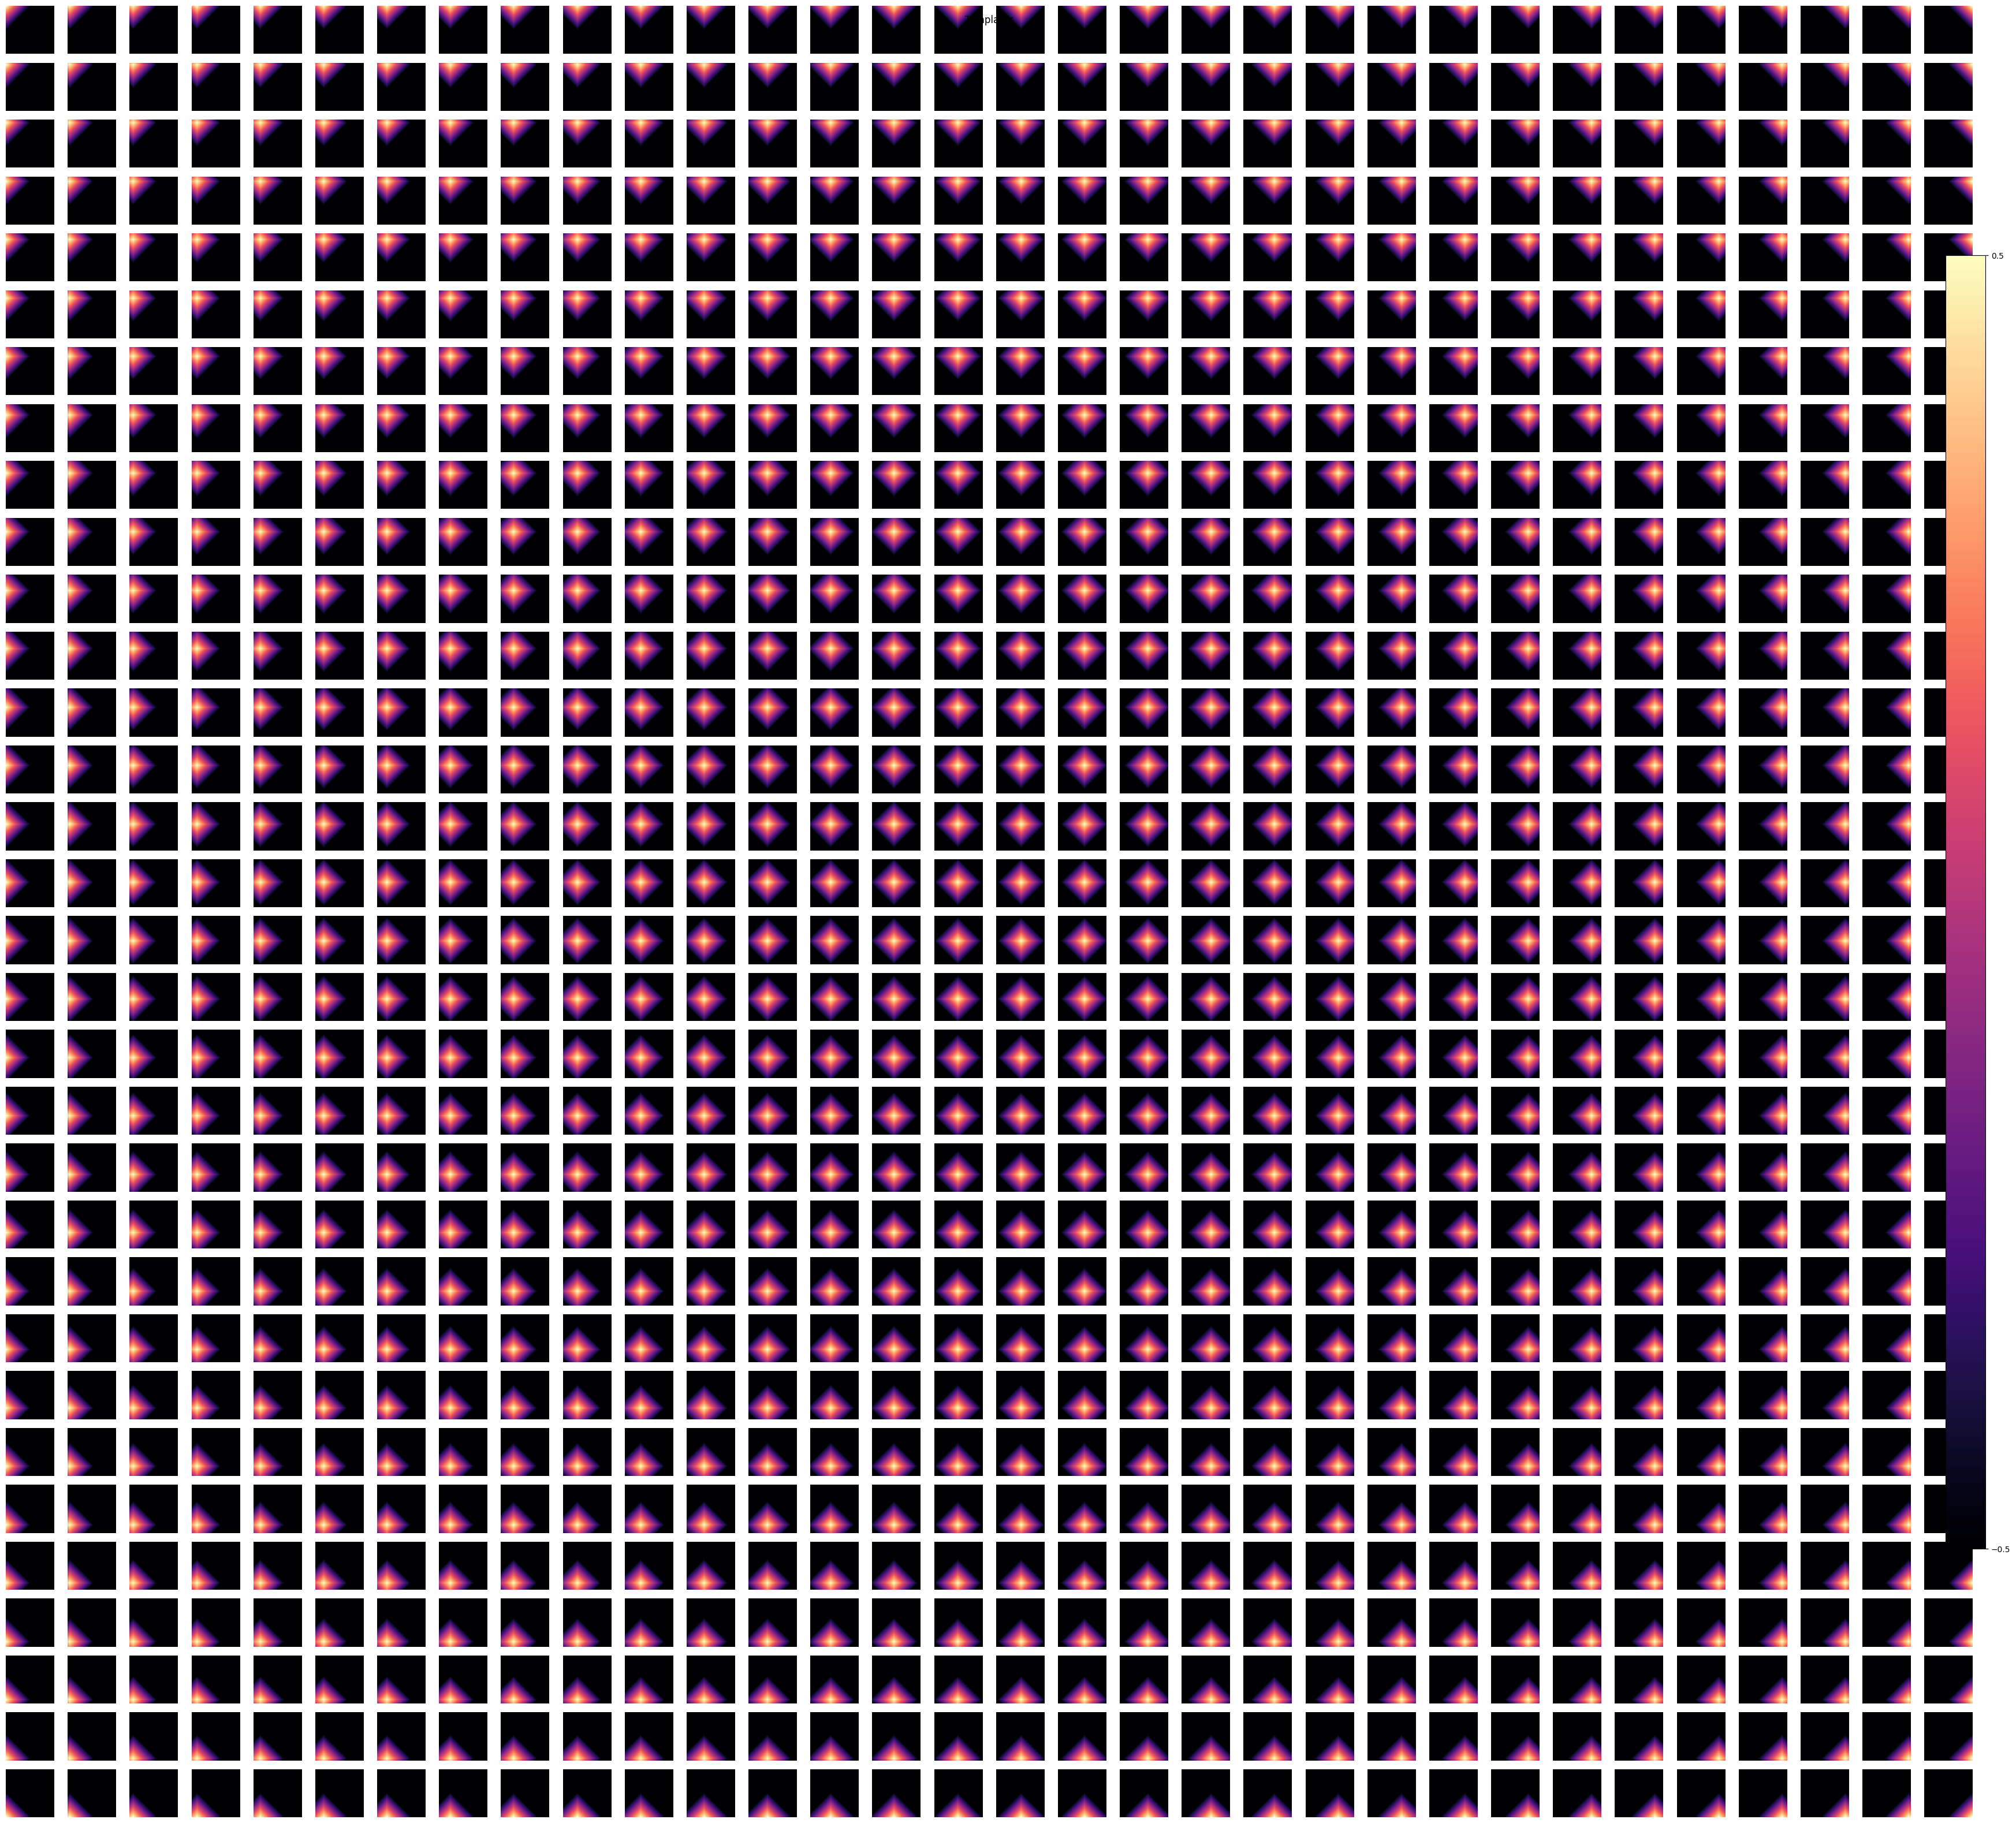

In [6]:
plot_tensors(interpretable_cnn.templates.unsqueeze(0), title='Templates')

In [12]:
#### Ejemplo de uso con una imagen de 32 x 32

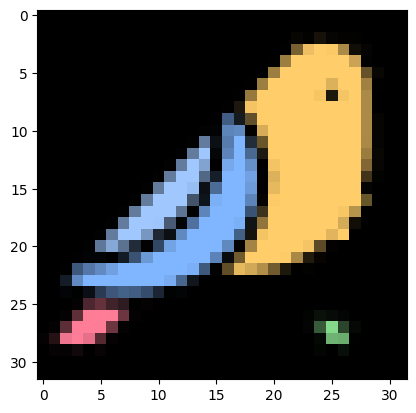

In [13]:
image = Image.open("examples/bird_32_32.png")
image_as_tensor = ToTensor()(image).unsqueeze(0)[:, :3, :, :]
plt.imshow(ToPILImage()(image_as_tensor[0]))

In [14]:
output = interpretable_cnn(image_as_tensor)
output.shape

torch.Size([1, 3, 32, 32])

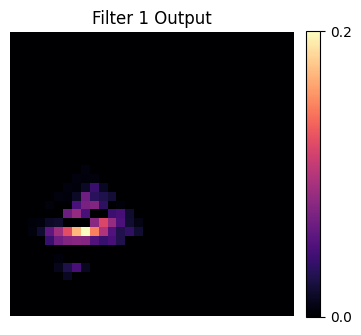

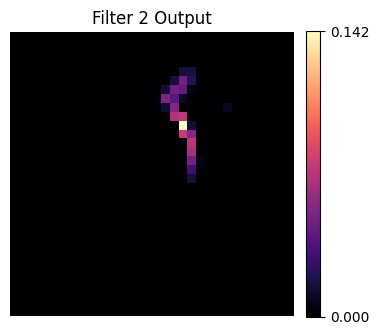

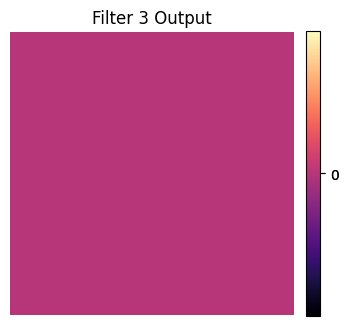

In [16]:
for i in range(filters):
    image = output[0, i, :, :]
    plot_tensor(image, title=f"Filter {i+1} Output")

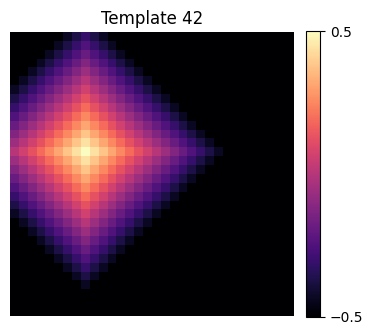

In [17]:
plot_tensor(interpretable_cnn.templates[424], title="Template 42")

In [11]:
def calculate_p_x_T(X, templates):
    tr_x_ts = torch.exp(torch.mul(templates.unsqueeze(1), X.unsqueeze(2)))
    Z = tr_x_ts.sum(dim=(0))
    p_x_T = (1 / Z) * tr_x_ts
    return p_x_T

In [12]:
output.shape

torch.Size([1, 3, 32, 32])

In [13]:
calculate_p_x_T(output, interpretable_cnn.templates.unsqueeze(0)).min()

tensor(1.0000, grad_fn=<MinBackward1>)

In [37]:
def mutual_information(X, templates):
    n = templates.shape[-1]
    filters = X.shape[0]

    p_x_T_extended = calculate_p_x_T(X, templates)
    print(p_x_T_extended.max(), 'p_x_T_extended max')
    print(p_x_T_extended.shape, 'p_x_T_extended')
    sum_p_T = 1 / (n*n)
    sum_p_X = sum_p_T * p_x_T_extended.sum(dim=(2))
    print(sum_p_X.max(), 'sum_p_X max')
    print(sum_p_X.shape, 'sum_p_X')
    p_x_T = p_x_T_extended.prod(dim=1).prod(dim=1).unsqueeze(1)
    # print(p_x_T.max(), 'p_x_T max')
    # print(p_x_T.shape, 'p_x_T')
    # print(sum_p_X.shape, 'sum_p_X')
    mi = - sum_p_X.prod(dim=(1)) * p_x_T * torch.log(((p_x_T + 1e-10) / (sum_p_X + 1e-10))).prod(dim=(1))
    return mi.sum()

In [38]:
x = mutual_information(output.repeat(9, 1, 1, 1), interpretable_cnn.templates.unsqueeze(0).repeat(9, 1, 1, 1))
x

tensor(0.1111, grad_fn=<MaxBackward1>) p_x_T_extended max
torch.Size([9, 3, 1024, 32, 32]) p_x_T_extended
tensor(0.1111, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([9, 3, 32, 32]) sum_p_X


tensor(0., grad_fn=<SumBackward0>)

In [1]:
def MI2(X, templates):
    filters = X.shape[1]
    n_templates = templates.shape[1]
    n = templates.shape[-1]
    X_ = X.unsqueeze(1)
    templates_ = templates.unsqueeze(2)
    p_x = (X_.sum(dim=(3, 4)) / (n*n*filters)).unsqueeze(-1).unsqueeze(-1)
    # print(p_x)
    p_T = (templates_.sum(dim=(3, 4))  / (n*n*n_templates)).unsqueeze(-1).unsqueeze(-1)
    # print(p_T)
    p_x = (p_x > 0).float()
    p_T = (p_T > 0).float()
    # print(X_.matmul(templates_))
    # print(X_.matmul(templates_).shape)
    # print((p_x * p_T))
    p_x_T = (X_.matmul(templates_) / (p_x * p_T)).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

    p_x_expanded = p_x.unsqueeze(-1).unsqueeze(-1)
    MI = - (p_x_T) * torch.log2((p_x_T + 1e-10) ) / ((p_x * p_T) + 1e-10)
    return MI.sum()

In [2]:
a = output.repeat(9, 1, 1, 1)
b = interpretable_cnn.templates.unsqueeze(0).repeat(9, 1, 1, 1)
print(a.shape)
print(b.shape)
x = MI2(a, b, 32)
x

NameError: name 'output' is not defined

In [16]:
class Model(nn.Module):
    def __init__(self, feature_map_size):
        super().__init__()
        self.cnn = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.icnn = InterpretableConvLayer(in_channels=16, out_channels=6, kernel_size=3, feature_map_size=16)
        self.classifier = nn.Linear(384 , 10)

    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = nn.ReLU()(x)
        x = self.icnn(x)
        x = nn.ReLU()(x)
        icnn_output = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = torch.softmax(x, dim=1)
        return x, icnn_output


In [17]:
torch.softmax(torch.tensor([0.1, 0.2, 0.3]), dim=0)

tensor([0.3006, 0.3322, 0.3672])

In [18]:
transformations = Compose([
    Resize((32, 32)),
    ToTensor()
])

In [19]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transformations)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transformations)

In [20]:
mnist_trainset[0][1]

5

In [21]:
def one_hot_encode(y, n_classes=10):
    y_one_hot = torch.zeros((n_classes))
    y_one_hot[y] = 1
    return y_one_hot

In [22]:
one_hot_encode(mnist_trainset[0][1])

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [23]:
# Transform target to one-hot encoding
mnist_trainset.target_transform = lambda x: one_hot_encode(x, n_classes=10)
mnist_testset.target_transform = lambda x: one_hot_encode(x, n_classes=10)


In [24]:
BATCH_SIZE = 64
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
model = Model(feature_map_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

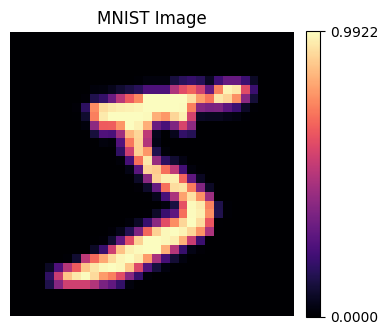

In [26]:
plot_tensor(mnist_trainset[0][0].permute(1, 2, 0), title="MNIST Image")

In [27]:
x, icnn_output = model(mnist_trainset[0][0].unsqueeze(0))
icnn_output.shape

torch.Size([1, 6, 16, 16])

In [28]:
model.icnn.templates.unsqueeze(0).shape

torch.Size([1, 256, 16, 16])

In [29]:
icnn_output.max()

tensor(0.1719, grad_fn=<MaxBackward1>)

In [30]:
lambda_ = 0.003
EPOCHS = 5

losses = {
    "total_loss": [],
    "class_loss": [],
    "interp_loss": []
}
model.train()
for epoch in trange(EPOCHS):
    for images, labels in tqdm(train_dataloader, desc="Training", leave=False):   
        y_pred, icnn_output = model(images)
        
        # Clasificación
        class_loss = criterion(y_pred.squeeze(1), labels.float())

        # Interpretabilidad
        is_pos = labels.bool()

        templates = model.icnn.templates.unsqueeze(0).repeat(BATCH_SIZE, 1, 1, 1)
        interp_loss = mutual_information(icnn_output, templates)
        print(f"Mutual Information: {interp_loss.item():.4f}")
        print(f"Class Loss: {class_loss.item():.4f}")
        total_loss = lambda_ * interp_loss + (1 - lambda_) * class_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        #print(f"Epoch {epoch+1}/{EPOCHS}, Batch Loss: {total_loss.item():.4f}, Class Loss: {class_loss.item():.4f}, Interp Loss: {interp_loss.item():.4f}")
        

    losses["total_loss"].append(total_loss.item())
    losses["class_loss"].append(class_loss.item())
    losses["interp_loss"].append(interp_loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Total Loss: {total_loss.item():.4f}, Class Loss: {class_loss.item():.4f}, Interp Loss: {interp_loss.item():.4f}")



  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

tensor(4.0233, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481940480.0000
Class Loss: 2.3024
tensor(4.0302, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481942528.0000
Class Loss: 2.3029
tensor(4.0331, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481945088.0000
Class Loss: 2.3027
tensor(4.0420, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481948672.0000
Class Loss: 2.3029
tensor(4.0503, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481952256.0000
Class Loss: 2.3025
tensor(4.0415, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481956864.0000
Class Loss: 2.3017
tensor(4.0522, grad_fn=<MaxBackward1>) sum_p_X max
torch.Size([64, 6, 16, 16]) sum_p_X
Mutual Information: -6481963008.0000
Class Loss: 2.3019

KeyboardInterrupt: 

In [91]:
losses["interp_loss"]

[-65153.81640625,
 -65153.81640625,
 -65153.81640625,
 -65153.81640625,
 -65153.81640625]